## Natural Language Processing - Project

#### Technology opportunity discovery by structuring user needs based on natural language processing and machine learning

Taeyeoun Roh, Yujin Jeong, Hyejin Jang, Byungun YoonID*

[Research Paper](paper.pdf)

In [6]:
pip install numpy
pip install wordcloud
pip install spacy
pip install nltk
pip install matplotlib
pip install pandas
pip install networkx
pip install gensim
pip install sklearn
pip install torch===1.5.0 torchvision===0.6.0 -f https://download.pytorch.org/whl/torch_stable.html
pip install stanza    

^C
  Using cached https://files.pythonhosted.org/packages/27/9c/60689521a971a57dd02d2925105efedefa9dccd76c9a0b92566683d43e89/stanza-1.0.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/92/30/1b7ccde09bf0c535d11f18a574ed7d7572c729a8f754fd568b297be08b61/protobuf-3.11.3-cp37-cp37m-win_amd64.whl

  Could not find a version that satisfies the requirement torch>=1.3.0 (from stanza) (from versions: 0.1.2, 0.1.2.post1, 0.1.2.post2)
No matching distribution found for torch>=1.3.0 (from stanza)


In [2]:
# Importing all dependencies
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy
nlp = spacy.load('en_core_web_sm')
pd.set_option('display.max_colwidth',100)
pd.set_option('max_rows', 60)

ModuleNotFoundError: No module named 'pandas'

### Load dataset

In [ ]:
# Read data from csv
data = pd.read_csv("reviews_iphone.csv")

In [ ]:
df = pd.DataFrame(data)

### Remove any tabs and line breaks

In [ ]:
df.review_text = df.review_text.apply(lambda x: x.replace("\n","."))
df.review_text = df.review_text.apply(lambda x: x.replace("\t","."))
df

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn' # Set to remove SettingWithCopyWarning

### Use sentence tokeniser on the corpus

In [ ]:
df['tokenized_text'] = df['review_text'].apply(lambda x: sent_tokenize(x))

In [ ]:
df.to_csv("df.csv")

In [ ]:
# Create a distinct index column for tracking purpose later
df.insert (0,"idx",df.index)
df

### Flatten DataFrame to get every sentence in separate lines

In [ ]:
sent = df.tokenized_text.apply(pd.Series)\
    .melt() \
    .dropna().reset_index().drop(["index","variable"], axis=1)

# All the sentences. Ready for opinion extraction.
sent

### Convert tokenized sentences into nlp objects

In [ ]:
sent['nlp'] = sent['value'].apply(lambda x: nlp(x))
sent.loc[sent.index == 225]

### Perform lemmatization for each word in sentence

In [ ]:
sent['lemma'] = sent['nlp'].apply(lambda x: [word.lemma_ for word in x])
sent

### POS Tagging for corpus

In [ ]:
sent['pos'] = sent['nlp'].apply(lambda x: [(i,i.tag_) for i in x])
sent

### TF-IDF calculations

In [ ]:
# Create a copy of the dataframe
dl = sent
dl

In [ ]:
# Split sentences into words for idf calculations
dl['words'] = dl.value.str.strip().str.split('[\W_]+')

In [ ]:
dl

In [ ]:
# Create a words list with the correct POS tagging

dl['idx'] = dl.index
rows = list()
for row in dl[['idx', 'pos']].iterrows():
    r = row[1]
#     print(r.pos)
    for index,word in enumerate(r.pos):
        rows.append((r.idx, word[0],word[1]))

words = pd.DataFrame(rows, columns=['idx', 'word','pos'])
words.to_csv("word.csv")

In [ ]:
words

In [ ]:
# convert words to lower case for matching with corresponding tf-idf calculations
words['word'] = words['word'].apply(lambda x: str(x).lower())
words.head()

In [ ]:
# Copy of dataframe to be used later
word_pos = words.copy() # here we keep a copy of the word/pos dataframe for merging later with our tf-idf calculations

In [ ]:
word_pos

In [ ]:
# Calculation of TF-IDF

counts = words.groupby('idx')\
    .word.value_counts()\
    .to_frame()\
    .rename(columns={'word':'n_w'})

word_sum = counts.groupby(level=0)\
    .sum()\
    .rename(columns={'n_w': 'n_d'})

tf = counts.join(word_sum)

tf['tf'] = tf.n_w/tf.n_d

c_d = words.idx.nunique()

idf = words.groupby('word')\
    .idx\
    .nunique()\
    .to_frame()\
    .rename(columns={'idx':'i_d'})\
    .sort_values('i_d')

idf['idf'] = np.log(c_d/idf.i_d.values)

tf_idf = tf.join(idf)

tf_idf['tf_idf'] = tf_idf.tf * tf_idf.idf

tf_idf.sort_values(by='idf')

idf = tf_idf[['idf']]
idf['word'] = idf.index
idf['words'] = idf.word.apply(lambda x: x[1])
idf = idf.drop(columns=['word'],axis=1)
idf = idf.reset_index()
idf = idf.drop(columns=['words','idx'],axis=1)
idf = idf.sort_values(by='idf',ascending=True)
idf = idf.drop_duplicates()

### Combining TF-IDF and POS tagged word list

In [3]:
tf_idf

NameError: name 'tf_idf' is not defined

In [ ]:
word_pos

In [ ]:
combined = word_pos.join(tf_idf, on=['idx','word'],how='left')
combined

In [ ]:
# Clean up NaN
combined.dropna()

### Extract Sentiment Keywords

In [ ]:
sentiment_keywords = combined[combined['pos'].str.startswith(("JJ","RB"), na = False)]
sentiment_keywords

In [ ]:
sentiment_keywords.sort_values(by='idf')

In [ ]:
sentiment_keywords.to_csv("sent_key.csv")

Filtering by IDF > 2.4

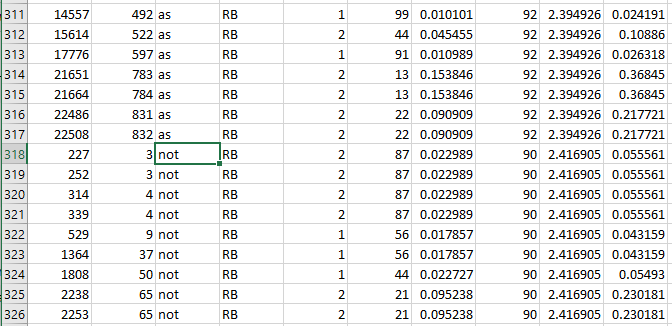

In [ ]:
sentiment_keywords = sentiment_keywords.loc[sentiment_keywords.idf > 2.4]
sentiment_keywords

### Generate Word Cloud

In [ ]:
word_cloud = WordCloud().generate(' '.join(sentiment_keywords['word']))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20,20))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
unique_keywords = pd.DataFrame(sentiment_keywords['word'].unique())
unique_keywords

In [ ]:
keywords = sentiment_keywords['word'].unique()
keywords

In [ ]:
sentiments = pd.DataFrame(sent['value'])
sentiments

In [ ]:
# our dataframe
import string
sentiments['value'] = sentiments['value'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [ ]:
def contains_keyword(value):
    wrds = value.split()
    for wrd in wrds:
        if (wrd in keywords):
            return 1
    return 0

In [ ]:
# Test of above function
contains_keyword("This is not a car")

In [ ]:
sentiments['value'] = sentiments['value'].apply(lambda x: str(x).lower())
sentiments

In [ ]:
sentiments['has_keyword'] = sentiments['value'].apply(lambda x: contains_keyword(x))
sentiments

In [ ]:
sentiments.loc[sentiments.has_keyword == 0]

### Training a Naive Bayes Classifier to detect possibility of sentiment

In [ ]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score, accuracy_score
nltk.download('stopwords')

In [ ]:
stopset = set(stopwords.words('english'))
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True, strip_accents='ascii', stop_words=stopset)

In [ ]:
y = sentiments.has_keyword
x = vectorizer.fit_transform(sentiments.value)

print(y.shape)
print(x.shape)

In [ ]:
# Create test train split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,random_state=0, test_size=0.1)

# Training a Naive Bayes Classifier
model = naive_bayes.MultinomialNB()
model.fit(xtrain, ytrain)

# Test accuracy
# roc_auc_score(ytest, model.predict_proba(xtest)[:,1])
accuracy_score(ytest,model.predict(xtest))

In [ ]:
sentiments['pred'] = sentiments['value'].apply(lambda x: model.predict_proba(vectorizer.transform(np.array([x])))[0][1])
sentiments['class'] = sentiments['value'].apply(lambda x: model.predict(vectorizer.transform(np.array([x])))[0])
sentiments

In [ ]:
sentiments.loc[sentiments['has_keyword'] ==  0]

In [ ]:
sentiments.to_csv("sentiments.csv")

sentiments.sort_values(by='pred')

### Extract Opinion Triggers

Here we focus of nouns only also known as Functional Opinion Triggers

In [ ]:
# rows = list()
# sent['idx'] = sent.index
# for row in sent[['idx','pos']].iterrows():
#     r = row[1]
# #     print(r.pos)\
#     current = ""
#     for index,word in enumerate(r.pos):
#         if(word[1].startswith('NN')):
#             current = current + " " + str(word[0])
#         elif(len(current)>0):
#             rows.append(current)
#             current = ""
            
# #             print(word[1])
# #         rows.append((r.idx, word[0],word[1]))
# noun = pd.DataFrame(rows,columns=['nouns'])
# # noun = pd.DataFrame(noun['nouns'].unique(), columns=['nouns'])
# noun


rows = list()
sent['idx'] = sent.index
for row in sent[['idx','pos']].iterrows():
    r = row[1]
#     print(r.pos)\
    current = ""
    for index,word in enumerate(r.pos):
        if(word[1].startswith('NN')):
            rows.append(word[0])
            
#             print(word[1])
#         rows.append((r.idx, word[0],word[1]))
noun = pd.DataFrame(rows,columns=['nouns'])
# noun = pd.DataFrame(noun['nouns'].unique(), columns=['nouns'])
noun


In [ ]:

noun['count'] = 1
noun

In [ ]:
noun['nouns'] = noun['nouns'].apply(lambda x: str(x).lower())
noun

In [ ]:

noun = noun.groupby('nouns').count()


In [ ]:
noun = noun.sort_values(by='count',ascending=False)
noun.head(20)

### Naive Bayes to find Opinion Triggers

This is defined in the following excerpt from the research paper

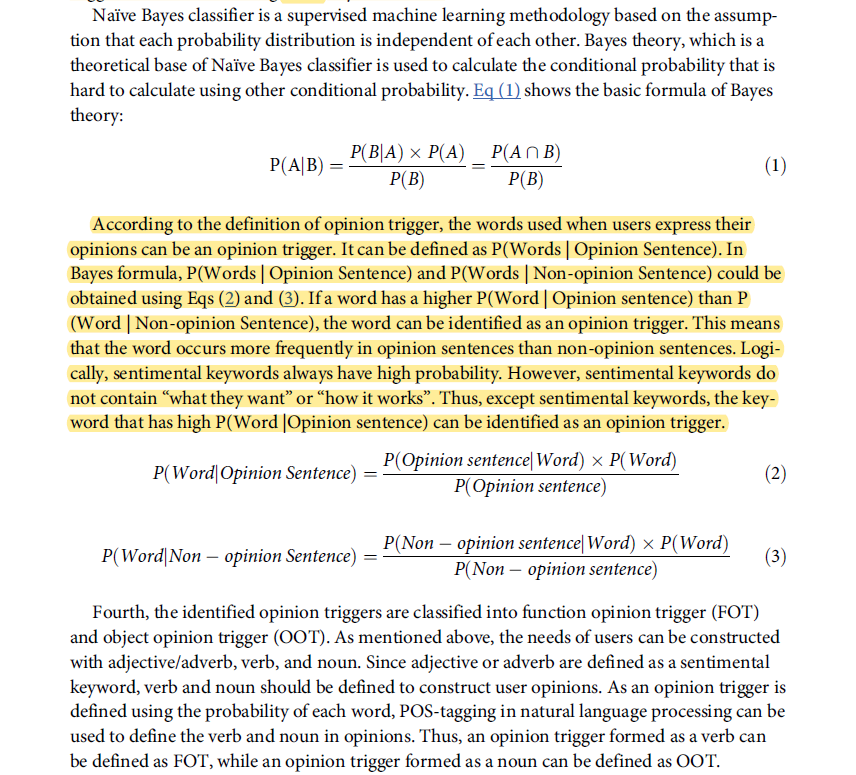

Since this is a very unique case, we could calculate all the probabilities ourselves.

In our corpus, which contains 1009 sentences and out of which 71 are classified as non-sentiment.

In [ ]:
#Given our Opinion Keywords
noun.head(20)

We can now pull up all the adjectives and adverbs used commonly with the above opinion triggers.

In [ ]:
dl.pos

In [ ]:
dl

In [ ]:
# Testing the size of longest sentence
tempdf = pd.DataFrame(dl.words, columns=['words'])
tempdf

In [ ]:
tempdf['length'] = tempdf.words.apply(lambda x: len(x))

tempdf.sort_values(by='length')


In [ ]:
tempdf.to_csv("temp.csv")

In [ ]:
noun

In [ ]:
noun.index

In [ ]:
dl['value'].apply(lambda x: x.lower())

### Dependency Parsing

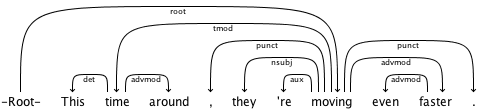

https://nlp.stanford.edu/software/nndep.html

Danqi Chen and Christopher Manning. 2014. A Fast and Accurate Dependency Parser Using Neural Networks. In Proceedings of EMNLP 2014.

In [ ]:
import stanza
stanza.download('en') # download English model
nlp = stanza.Pipeline('en') # initialize English neural pipeline
doc = nlp("Barack Obama was born in Hawaii.  He was elected president in 2008.")
doc.sentences[0].print_dependencies()

In [ ]:
doc = nlp("The iPhone SE is an extremely solid entry-level iPhone.")
# doc.sentences[0].print_dependencies()
# print(doc.sentences[0].dependencies)
# for word in doc.sentences[0].words:
#     print(f'word: {word.text}\tparent token: {word.parent.text}')
nodes = []
edges = []
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in doc.sentences for word in sent.words], sep='\n')

#         print(line)
#         deprel_stack.append(word.deprel)
    
# print(array)

In [4]:

import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
# G.add_edge(1,2)
# G.add_edge(1,3)
mapping = {'0': 'Root'}
for sent in doc.sentences: 
    for word in sent.words:
        G.add_edge(str(word.id),str(word.head))
        mapping.update({word.id : word.text + " : " + word.upos})
#         print(word)
#         line = [, word.text, word.head, word.deprel]
#         array.append(line)
# print(mapping)
# print(G.nodes())
G = nx.relabel_nodes(G,mapping)
# print(G.nodes())
nx.draw_networkx(G, with_labels=True)
plt.show()

ModuleNotFoundError: No module named 'networkx'

In [ ]:
# Given example
doc = nlp("IPhone SE is a great phone protector")

deprel_stack = []
for sent in doc.sentences: 
    for word in sent.words:
        deprel_stack.append(word.deprel)
        
print(deprel_stack)

In [ ]:
noun

In [ ]:
dl

In [ ]:
# for row in dl['value']:
rows = ["This Iphone SE is amazing","Iphone is great phone from Best Buy.","The Iphone SE II is coming next week"]

key = "Iphone"
for row in rows: 
    doc = nlp(row)
    for sent in doc.sentences: 
        for word in sent.words:
            if(word.text == key):
                print("Found", word.id)            
    G = nx.Graph()
    # G.add_edge(1,2)
    # G.add_edge(1,3)
    mapping = {'0': 'Root'}
    for sent in doc.sentences: 
        for word in sent.words:
            G.add_edge(str(word.id),str(word.head))
            mapping.update({word.id : word.id + ":" + word.text + "\n" + word.upos})
            print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in doc.sentences for word in sent.words], sep='\n')
    #         print(word)
    #         line = [, word.text, word.head, word.deprel]
#             array.append(line)
    # print(mapping)
    # print(G.nodes())
    G = nx.relabel_nodes(G,mapping)
    # print(G.nodes())
    nx.draw_networkx(G, with_labels=True)
    plt.show()

### Using Word2Vec to identify needs

https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/

In [ ]:
import warnings 

warnings.filterwarnings(action = 'ignore') 
  
import gensim 
from gensim.models import Word2Vec 

In [ ]:
data = []
for i in dl['value']:
    tmp = []
    for j in word_tokenize(i):
        tmp.append(j.lower())
    data.append(tmp)
    
model1 = gensim.models.Word2Vec(data, window = 5, min_count = 1, iter = 1000) 
model2 = gensim.models.Word2Vec(data, min_count = 1, window = 5, sg = 1, iter = 1000) 

In [ ]:
noun

In [ ]:
# Now we can test every noun with sentiment keyword

noun['nouns'] = noun.index
# noun.reset_index()
# noun['idx'] = noun.reset_
noun

In [ ]:
keywords

In [ ]:
threshold1 = 0.5
threshold2 = 0.4
def fetch_close_words(x, model):
    output = []
    for i in list(noun.nouns):
        try:
            if(model.similarity(x,i)>threshold1):
                output.append(i)
        except:
            pass
    return output

def fetch_keywords_words(x, model):
    output = []
    for i in keywords:
        try:
            if(model.similarity(x,i)>threshold2):
                output.append(i)
        except:
            pass
    return output

In [ ]:
word1 = "pixel"
word2 = "sheet"
print(model1.similarity(word1,word2))
print(model2.similarity(word1,word2))
print(model1.similarity(word1,word2))
print(model2.similarity(word1,word2))

In [ ]:
noun['model1'] = noun['nouns'].apply(lambda x: fetch_close_words(x,model1))
noun['model2'] = noun['nouns'].apply(lambda x: fetch_close_words(x,model2))
noun['k1'] = noun['nouns'].apply(lambda x: fetch_keywords_words(x,model1))
noun['k2'] = noun['nouns'].apply(lambda x: fetch_keywords_words(x,model2))

In [ ]:
noun.to_csv("wrd2vec.csv")

In [ ]:
data

In [ ]:
model1.similarity("iphone","samsung")

In [ ]:
from sklearn.manifold import TSNE
model = model1
X = model[model.wv.vocab]
print(len(X))
print (X[0])
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X[:1000,:])

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

model = model2
X = model[model.wv.vocab]
print(len(X))
print (X[0])
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X[:1000,:])

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()